In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from bartpy.bartpy.sklearnmodel import SklearnModel
from tqdm import tqdm

from scipy.special import logit, expit
from scipy.stats import bernoulli

import simulate_data.simulate_data as sd

In [2]:
n=250
N_replications=1
# data
data = sd.make_zaidi_data_B(n)
Y,W,X,tau,pi = sd.get_data(data,n,1)
#X = data["Xy"]
Y_i_star = sd.get_Y_i_star(Y,W,pi)
y_i_star_min = np.min(Y_i_star)
y_i_star_max = np.max(Y_i_star)
delta = y_i_star_max - y_i_star_min
Y1=data["Y1"]
Y0=data["Y0"]
#tau = Y1-Y0
#h = Y1/pi + Y0/(1-pi)
#sigma_true = np.mean(Y_i_star - tau - h*(W-pi))
#g_in_bart = (tau-y_i_star_min)/delta -0.5 
#h_in_bart = (Y1/pi + Y0/(1-pi))/delta

In [3]:
n_chains = 1
n_samples=25000
n_burn_in=0


kwargs = {
    "model": "causal_gaussian_mixture",
}

In [4]:
model = SklearnModel(
    n_samples=n_samples, 
    n_burn=n_burn_in,
    n_trees_h=150,
    n_trees_g=150,
    alpha = 0.95,
    beta = 2,
    k=2,
    thin=1,
    n_chains=n_chains,
    n_jobs=1,
    store_in_sample_predictions=True,
    nomalize_response_bool = False,
    **kwargs
)

Causal Gaussian Mixture using Transformed Outcomes...


In [5]:
model.fit_CGM(X, Y_i_star, W, pi)

0it [00:00, ?it/s]
  0%|          | 0/25000 [00:00<?, ?it/s]


Starting burn
Starting sampling


100%|██████████| 25000/25000 [1:04:40<00:00,  6.44it/s]


/Users/omarchavez/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


SklearnModel(beta=2, k=2, n_burn=0, n_chains=1, n_jobs=1, n_samples=25000,
             n_trees=None, n_trees_g=150, n_trees_h=150,
             store_in_sample_predictions=True, thin=1)

In [9]:
sigma = np.zeros((n_samples, n_chains,N_replications))
pred_g = np.zeros((n, n_samples, n_chains, N_replications))
pred_h = np.zeros((n, n_samples, n_chains, N_replications))

for i in tqdm(range(N_replications)):
    
    sigma_samples = np.array_split(
        [x.sigma.current_value() for x in model.model_samples_cgm], 
        n_chains
    )
    
    for nc in range(n_chains):
        sigma[:,nc,i] = sigma_samples[nc]
        pred_g[:,:,nc,i] = np.array(model.extract[nc]['in_sample_predictions_g']).T 
        pred_h[:,:,nc,i] = np.array(model.extract[nc]['in_sample_predictions_h']).T 

100%|██████████| 1/1 [00:00<00:00,  3.60it/s]


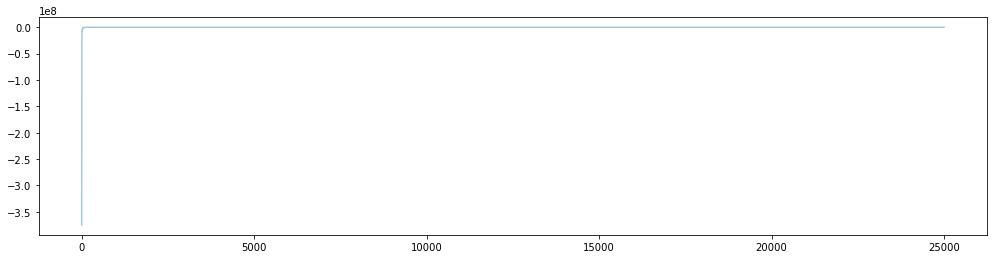

In [13]:

loaded_g = pred_g
loaded_h = pred_h
loaded_sigma = sigma

LL_s = np.zeros((n_samples,n_chains))

for c_i in range(n_chains):
    for s_i in range(n_samples):
        LL_s[s_i, c_i] = sd.CBARTMM_likelihood(
            resp=Y_i_star,
            W=W,p=pi,
            g=loaded_g[:,s_i,c_i],
            h=loaded_h[:,s_i,c_i],
            sigma=loaded_sigma[s_i, c_i]
        )
plt.figure(figsize=(17,4))
#plt.title("g:" + str(g_count) + " h:" + str(h_count) +" Mean LL:" + str(np.mean(LL_s[:,:])))
_=plt.plot(LL_s[:,:], alpha = 0.4)
_=plt.show()


In [41]:
np.mean((np.mean(loaded_g[:,10000:,0,0], axis=1)- tau)**2)

7.7723793409496515

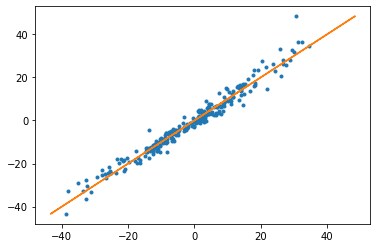

In [40]:
h = Y1/pi + Y0/(1-pi)
plt.plot(np.mean(loaded_g[:,10000:,0,0], axis=1), tau, '.')
plt.plot(tau,tau)

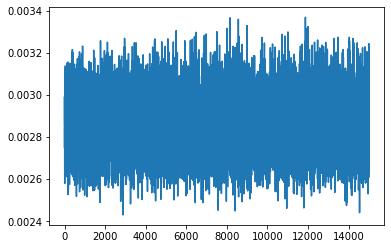

In [32]:
plt.plot(loaded_sigma[10000:,0,0])

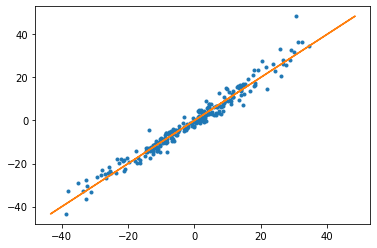

In [29]:
plt.plot(model.predict_CATE(), tau, '.')
plt.plot(tau,tau)

In [35]:
np.mean(model.predict_CATE(), axis=0)

-1.485982132611659

array([ 18.31973286, -17.11156746,  -0.64508725,  19.3204635 ,
         4.86547376,  -4.5507213 , -38.09006685, -12.57378431,
         2.15802679,  20.40486471, -13.6040552 ,   8.17442133,
        -8.68514683, -20.36462485, -10.40541542,  11.37074819,
       -10.28163598, -12.61800465,   2.95487949,  -4.65644664,
        -8.49600559,  -4.87232245, -11.02622655,   4.53892293,
         4.09611928,  -6.99124216, -15.02576097, -21.2918759 ,
        24.28842528,  21.85024754,   4.07354639,  11.34979111,
         6.66523043, -25.11146447, -17.86749494,  -6.13308255,
        34.49984909,  26.76470255,  15.23877647,  14.73258576,
         1.48651706,  -3.36549919,  14.0424787 ,   8.93387917,
        -8.37598104,  -0.74477959, -22.08641796,  11.57551814,
        -8.40529113,  -3.25582981, -11.78087803,  -8.92496067,
       -13.45102541,  28.91474145, -13.55474808, -19.60842006,
        12.98488926, -10.56944148, -11.51331907,   2.20980831,
        -5.62177033, -25.87962533,  -8.6995795 ,   7.28